# Q8- k-means clustering in latent space

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import OneHotEncoder,StandardScaler
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.metrics import accuracy_score

path=r"C:\Unipi-CS\5ο εξάμηνο\Αναγνώριση Προτύπων\project\Data\original dataset\crimes.csv"

data=pd.read_csv(path)

In [94]:
data_train=data[data["split"]=="TRAIN"]
data_val=data[data["split"]=="VAL"]
data_test=data[data["split"]=="TEST"]

categorical_features = ["weapon_code", "scene_type", "weather", "vic_gender"]
continuous_features = ["hour_float", "latitude", "longitude", "victim_age", "temp_c", "humidity", "dist_precinct_km", "pop_density"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [95]:
X_train = data_train.drop(columns=["killer_id", "split"])
X_val   = data_val.drop(columns=["killer_id", "split"])
X_test  = data_test.drop(columns=["killer_id", "split"])

y_train = data_train["killer_id"]
y_val_true = data_val["killer_id"]

In [96]:
X_train_transformed = preprocessor.fit_transform(X_train)

pca_full = PCA()
pca_full.fit(X_train_transformed)

PCA()

In [97]:

X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

In [98]:
m=3

In [99]:
Z_train = pca_full.transform(X_train_transformed)[:, :m]
Z_val = pca_full.transform(X_val_transformed)[:, :m]
Z_test = pca_full.transform(X_test_transformed)[:, :m]

In [100]:
killers=y_train.unique()
S = len(killers)
kmeans = KMeans(n_clusters=S, random_state=42, n_init=10)
train_clusters = kmeans.fit_predict(Z_train)

In [101]:
cluster_to_killer = {}
for q in range(S):
    killers_in_cluster = y_train.iloc[train_clusters == q]
    if not killers_in_cluster.empty:
        majority_killer = killers_in_cluster.mode()[0]
        cluster_to_killer[q] = majority_killer
    else:
        cluster_to_killer[q] = "Unknown"

In [102]:
y_val_true=data_val["killer_id"]
val_clusters = kmeans.predict(Z_val)
y_val_pred_km = np.array([cluster_to_killer[c] for c in val_clusters])
acc_val_km = accuracy_score(y_val_true, y_val_pred_km)

print(f"Unsupervised k-means VAL Accuracy: {acc_val_km:.4f}")

Unsupervised k-means VAL Accuracy: 0.8246


In [103]:
test_clusters = kmeans.predict(Z_test)
y_test_pred_km = np.array([cluster_to_killer[c] for c in test_clusters])

submission = pd.DataFrame({"killer_id": y_test_pred_km})
submission.to_csv(r"C:\Unipi-CS\5ο εξάμηνο\Αναγνώριση Προτύπων\project\Data\results\submissionQ8.csv", index=False)
print("Saved submissionQ8.csv")

Saved submissionQ8.csv


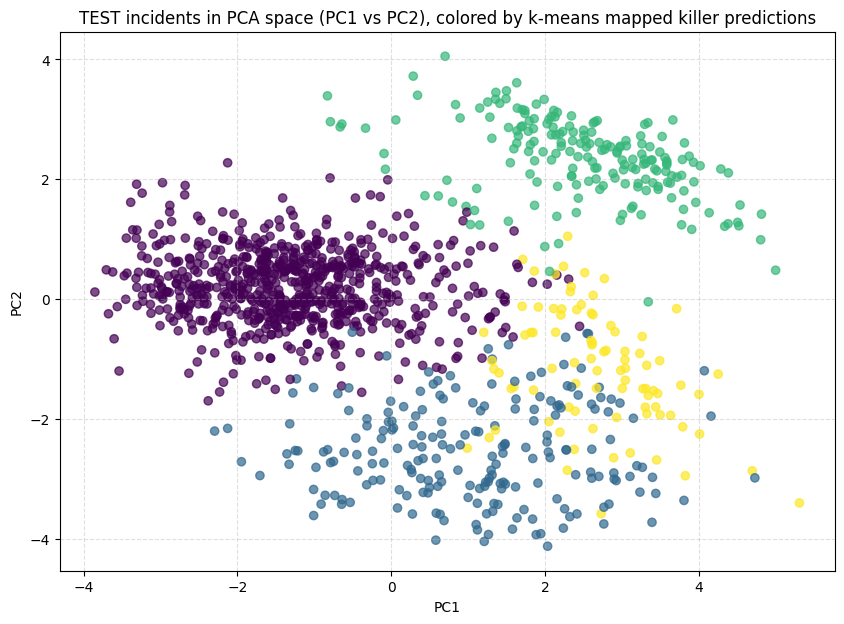

In [104]:

Z_test_2d = pca_full.transform(X_test_transformed)[:, :2]

color_ids = pd.factorize(y_test_pred_km)[0]

plt.figure(figsize=(10, 7))
plt.scatter(Z_test_2d[:, 0], Z_test_2d[:, 1], c=color_ids, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("TEST incidents in PCA space (PC1 vs PC2), colored by k-means mapped killer predictions")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

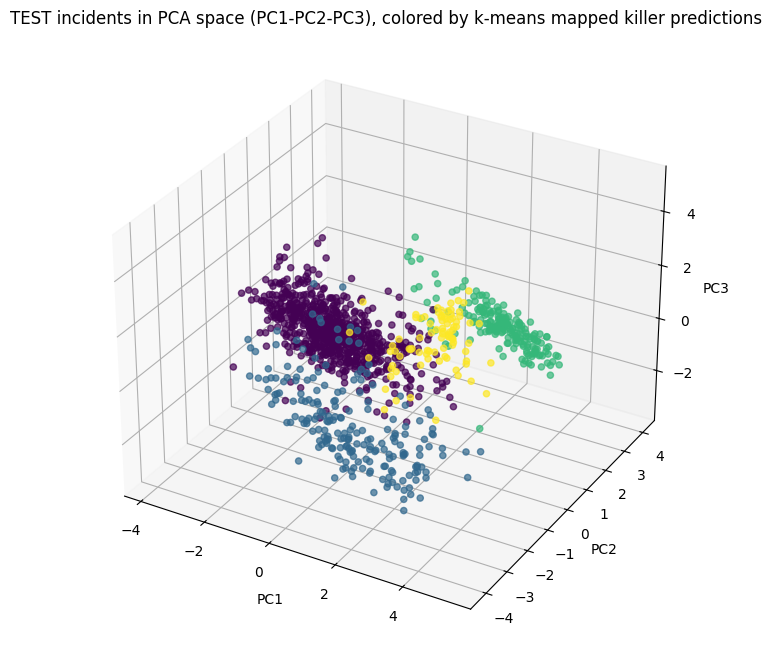

In [105]:
from mpl_toolkits.mplot3d import Axes3D  

Z_test_3d = pca_full.transform(X_test_transformed)[:, :3]
color_ids = pd.factorize(y_test_pred_km)[0]

fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    Z_test_3d[:, 0], Z_test_3d[:, 1], Z_test_3d[:, 2],
    c=color_ids, alpha=0.7, s=20
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("TEST incidents in PCA space (PC1-PC2-PC3), colored by k-means mapped killer predictions")

plt.show()